In [1]:
pretty = True
highres = True

%matplotlib inline
if highres:
    %config InlineBackend.figure_format = 'retina'
else:
    %config InlineBackend.figure_format = 'png'

#rcParams["figure.dpi"]=300

import sys
from pathlib import Path

pypsapath = "C:/dev/py/PyPSA/"

if sys.path[0] != pypsapath:
    sys.path.insert(0,pypsapath)

if Path("../..") not in [Path(p) for p in sys.path]:
    sys.path.insert(0,"../..")

%load_ext autoreload
%autoreload 2

In [2]:
import src.globals
from src.scigridnetwork import SciGRID_network
from src.armafitloader import ARMAfit_loader

Git root path found at: C:\dev\grid-analysis
Using data path:        C:\dev\grid-analysis\data


In [3]:
import pypsa
import numpy as np
import pandas as pd
import os
import itertools
import scipy.stats

import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib.dates
import matplotlib.font_manager
from matplotlib import rcParams

rcParams["font.family"] = "sans-serif"


from IPython.display import Markdown, display
printm = lambda s: display(Markdown(s))

In [4]:
sgn = SciGRID_network()

Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.



0.13.2 ['C:/dev/py/PyPSA\\pypsa']


In [5]:
month_index = 0
month_name = ARMAfit_loader.monthnames[month_index]

solar_diff_cov = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "solar_diffdaylightcov.npy")
wind_diff_cov = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "wind_diffcov.npy")
solar_diff_cov_norm = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "solar_diffdaylightcovnorm.npy")
wind_diff_cov_norm = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "wind_diffcovnorm.npy")

In [6]:
bus_diff_cov_day = wind_diff_cov + solar_diff_cov
bus_diff_cov_night = wind_diff_cov
bus_diff_cov_day_norm = wind_diff_cov_norm + solar_diff_cov_norm
bus_diff_cov_night_norm = wind_diff_cov_norm

bus_diff_cov_solar = solar_diff_cov

In [7]:
line_diff_cov_day = sgn.F @ bus_diff_cov_day @ sgn.F.T
line_diff_cov_night = sgn.F @ bus_diff_cov_night @ sgn.F.T

line_diff_cov_solar = sgn.F @ bus_diff_cov_solar @ sgn.F.T

In [8]:
armafits = ARMAfit_loader(sgn)

In [9]:
# sgn_fullyear = SciGRID_network()
# sgn_fullyear.network.generators_t.p_max_pu
# sgn2.network.generators_t.p_max_pu

In [10]:
printm("## `sgn`:")
printm("Average national solar generation: {0:.0f} MW".format(armafits.solar_generationmonth.sum(axis=0).mean()))
printm("Average national wind generation: {0:.0f} MW".format(armafits.wind_generationmonth.sum(axis=0).mean()))

## `sgn`:

Average national solar generation: 3170 MW

Average national wind generation: 10805 MW

In [11]:
sgn2= SciGRID_network(Path(pypsapath) / "examples" / "scigrid-de" / "scigrid-with-load-gen-trafos")
armafits2 = ARMAfit_loader(sgn2)

Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.



0.13.2 ['C:/dev/py/PyPSA\\pypsa']


In [12]:
printm("## `sgn2`:")
printm("Average national solar generation: {0:.0f} MW".format(armafits2.solar_generationmonth.sum(axis=0).mean()))
printm("Average national wind generation: {0:.0f} MW".format(armafits2.wind_generationmonth.sum(axis=0).mean()))

## `sgn2`:

Average national solar generation: 1975 MW

Average national wind generation: 22621 MW

In [13]:
sgn_jan1 = sgn.solar_generation[:,:24]
sgn2_jan1 = sgn2.solar_generation[:,:24]
coincide = np.all(sgn_jan1 == sgn2_jan1)

printm("`sgn` and `sgn2` **{}** coincide on January 1, 2011.".format("DO" if coincide else "DO NOT"))

`sgn` and `sgn2` **DO** coincide on January 1, 2011.

# 🌼

In [14]:
sgn.run_lopf_jan1()

Performing linear OPF for one day, 4 snapshots at a time:


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:45<00:00,  7.29s/it]


In [15]:
sgn2.run_lopf_jan1()

Performing linear OPF for one day, 4 snapshots at a time:


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:41<00:00,  6.86s/it]


In [16]:
sgn2_line_flow_jan1 = sgn2.line_flow_linear.values
sgn_line_flow_jan1 = sgn.line_flow_linear.values
coincide_line_flow = np.all(sgn2_line_flow_jan1 == sgn_line_flow_jan1)

printm("`sgn2` and `sgn` line flows **{}** coincide on January 1, 2011.".format("DO" if coincide_line_flow else "DO NOT"))

`sgn2` and `sgn` line flows **DO NOT** coincide on January 1, 2011.

# 🌷

In [17]:
fav_sgn = sgn

In [18]:
elevenAM = fav_sgn.network.generators_t.p.index[11]

print(f"Total load: {fav_sgn.network.loads_t.p_set.loc[elevenAM,:].sum()} MW")
print(f"Total generation: {fav_sgn.network.generators_t.p.loc[elevenAM,:].sum()} MW")
print(f"Generation overshoot: {fav_sgn.injection_total.loc[elevenAM,:].sum()} MW")

Total load: 52524.64000000083 MW
Total generation: 52950.84000000398 MW
Generation overshoot: 426.20000000314803 MW


In [19]:
#pd.Series(sgn2.line_saturation_total.values[11])
#sgn2.network.lines_t.p1.values[11]# / sgn2.network.lines.s_nom
#sgn2.line_flow_total

In [20]:
f = fav_sgn.line_saturation_nonlinear.values[11,:]

def true_prob(mu_l, sigma_l):
    return 1.0 - (scipy.stats.norm.cdf(1.0, loc=mu_l, scale=sigma_l) - scipy.stats.norm.cdf(-1.0, loc=mu_l, scale=sigma_l))

def rate(mu_l, sigma_l):
    return np.square(1-np.abs(mu_l))/(2.0*np.square(sigma_l))

line_ratings = pd.DataFrame({"l":fav_sgn.network.lines.index.values,
              "f": f,
              "σdiff_day": np.sqrt(np.diagonal(line_diff_cov_day)) / fav_sgn.line_threshold})

sigmaepsilon = 1
line_ratings["P>1"] = true_prob(line_ratings.f, line_ratings.σdiff_day*sigmaepsilon)
line_ratings["rate"] = rate(line_ratings.f, line_ratings.σdiff_day*sigmaepsilon)

line_ratings["Pnorm"] = line_ratings["P>1"] / np.max(line_ratings["P>1"])

line_ratings.sort_values("P>1", ascending=False).head(20)

,l,f,σdiff_day,P>1,rate,Pnorm
358,361,-0.700000,0.165036,0.034548,1.652178,1.000000
512,516,-0.700000,0.158361,0.029085,1.794393,0.841877
582,586,0.700000,0.156279,0.027451,1.842515,0.794585
583,587,0.699713,0.156215,0.027286,1.847559,0.789794
796,803,-0.700000,0.146402,0.020223,2.099520,0.585369
663,670,-0.700000,0.133020,0.012057,2.543194,0.348996
18,19,-0.700000,0.131519,0.011273,2.601575,0.326298
301,302,-0.698663,0.131094,0.010763,2.641853,0.311534
47,48,-0.699312,0.129811,0.010269,2.682752,0.297249
550,554,-0.643143,0.152758,0.009743,2.728687,0.282010


Text(0, 0.5, 'length')

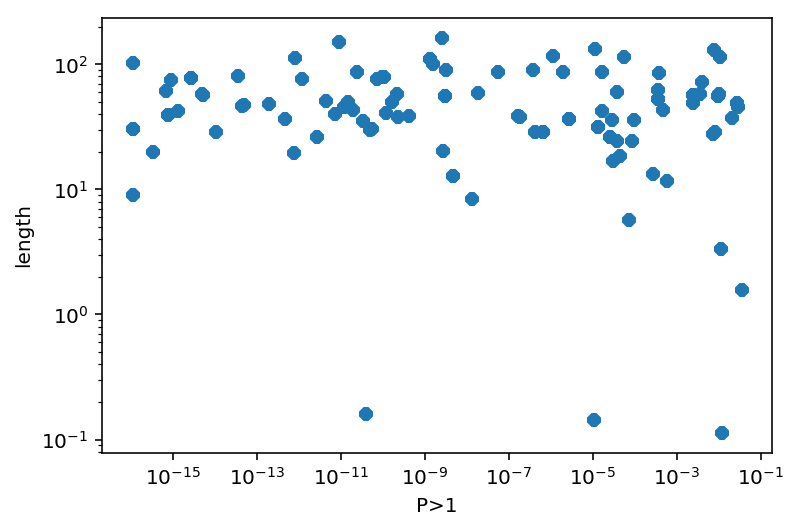

In [48]:
fig, ax = plt.subplots()


ax.set_xscale("log")
ax.set_yscale("log")

p = line_ratings["P>1"]
lengths = fav_sgn.network.lines.length.values

ax.plot(p[p>0], lengths[p>0], "8")
ax.set_xlabel("P>1")
ax.set_ylabel("length")

In [88]:
def most_likely_power_injection_given_line_failure(l):
    mup = fav_sgn.injection_total.loc[elevenAM]
    muf = fav_sgn.line_saturation_nonlinear.loc[elevenAM] # should be line_saturation_linear to be mathematically correct
    
    sigmap = bus_diff_cov_day
    sigmaf = (line_diff_cov_day * (1.0/fav_sgn.line_threshold)) * ((1.0/fav_sgn.line_threshold)[:,np.newaxis])
    
    def sign_mod(x):
        """The regular sign function, with the modification that `sign_mod(0.0)==1.0`, instead of zero."""
        return 1.0 if x >= 0.0 else -1.0
    
    return mup + (sign_mod(muf[l]) - muf[l]) / sigmaf[l,l] * (sigmap @ (fav_sgn.F[l] / fav_sgn.line_threshold[l]))
    

In [171]:
sorted(enumerate(fav_sgn.network.lines.length.values), key=lambda x: -x[1])

[(468, 203.683),
 (11, 200.291),
 (35, 195.877),
 (372, 194.59),
 (371, 194.53599999999997),
 (407, 179.49400000000003),
 (408, 179.483),
 (428, 169.144),
 (61, 163.671),
 (499, 158.686),
 (70, 156.914),
 (294, 152.12),
 (38, 149.01),
 (37, 134.922),
 (347, 132.974),
 (498, 131.762),
 (516, 131.429),
 (78, 130.685),
 (27, 129.863),
 (271, 125.443),
 (34, 124.574),
 (276, 123.741),
 (275, 123.721),
 (464, 123.64299999999999),
 (465, 123.15),
 (595, 121.63799999999999),
 (596, 121.60799999999999),
 (169, 121.485),
 (49, 120.96799999999999),
 (655, 120.885),
 (165, 119.387),
 (68, 118.95299999999999),
 (565, 116.059),
 (301, 114.939),
 (580, 114.917),
 (111, 114.491),
 (640, 113.53399999999999),
 (491, 112.73700000000001),
 (639, 112.46),
 (278, 111.236),
 (279, 111.228),
 (397, 111.17),
 (75, 110.35799999999999),
 (99, 110.113),
 (89, 110.031),
 (283, 106.704),
 (820, 105.02671053600001),
 (622, 104.68799999999999),
 (677, 104.48),
 (456, 104.459),
 (32, 104.169),
 (380, 103.557),
 (577,

In [89]:
line_ratings_reindexed = line_ratings.set_index("l")

In [174]:
l = 516


avg_dev = np.mean(np.abs(most_likely_power_injection_given_line_failure(l) - fav_sgn.injection_total.loc[elevenAM]))
avg_injection = np.mean(np.abs(fav_sgn.injection_total.loc[elevenAM]))

printm("Deviation is {:.0f}% of average injection.".format(100 * avg_dev / avg_injection))
pd.Series(np.abs(most_likely_power_injection_given_line_failure(l) - fav_sgn.injection_total.loc[elevenAM])).describe()

printm("Line is {} km.".format(fav_sgn.network.lines.length.values[l]))

Deviation is 50% of average injection.

Line is 131.429 km.

In [175]:
pd.Series((fav_sgn.F @ most_likely_power_injection_given_line_failure(l)) / fav_sgn.line_threshold).describe()

count    852.000000
mean      -0.003006
std        0.449579
min       -2.274157
25%       -0.181733
50%       -0.004178
75%        0.201301
max        1.621287
dtype: float64

Line is 131.429 km


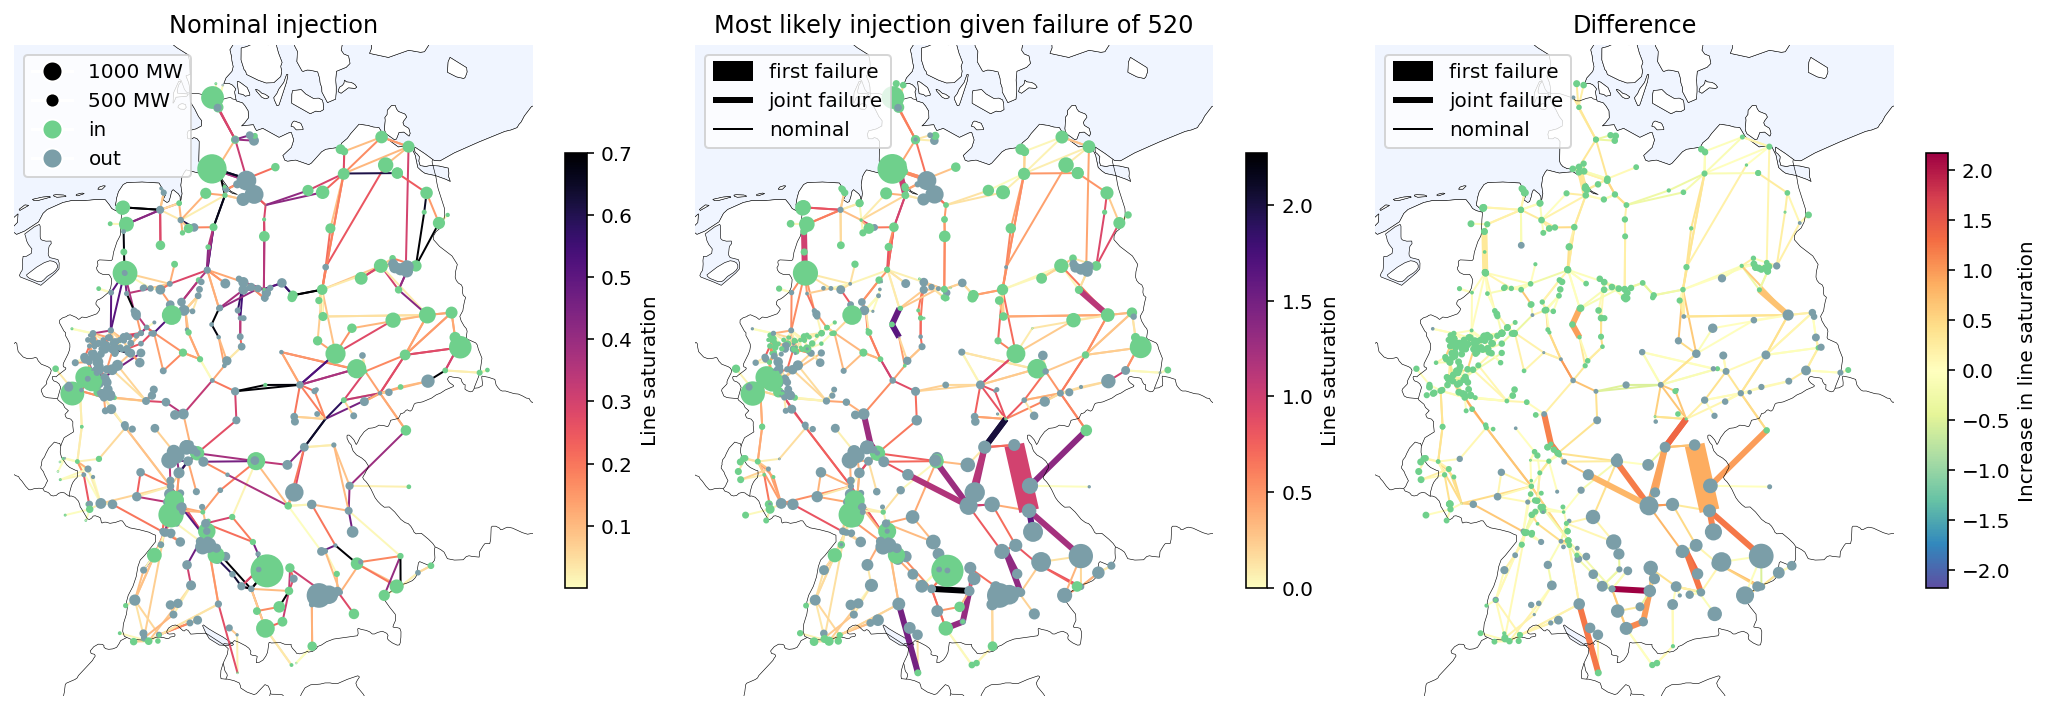

In [206]:
fig = plt.figure(figsize=(18,8))
import cartopy.crs as ccrs 
ax = fig.subplots(1,3,subplot_kw={"projection":ccrs.TransverseMercator(central_longitude=10.0, central_latitude=50.0)}).flatten()

geomap = "50m"


import cartopy.feature

def bus_array_to_plot(x):
    bus_sizes = [0]*len(fav_sgn.network.buses)
    bus_colors = ['g']*len(fav_sgn.network.buses)

    for i, bus_name in enumerate(fav_sgn.network.buses.index):
        if bus_name in fav_sgn.new_nodes:
            val = x[fav_sgn.node_index(bus_name)]
            bus_sizes[i] = np.abs(val) / 10
            bus_colors[i] = '#6fd08c' if val > 0 else '#7b9ea8'
    return bus_sizes, bus_colors


line_colors_flow = [np.abs(line_ratings_reindexed["f"][i]) for i in fav_sgn.network.lines.index]
line_widths=1
bus_sizes, bus_colors = bus_array_to_plot(fav_sgn.injection_total.loc[elevenAM])

pathcol, linecol = fav_sgn.network.plot(geomap=geomap, bus_sizes=bus_sizes, bus_colors=bus_colors, line_colors=line_colors_flow, line_widths=line_widths, line_cmap="magma_r", ax=ax[0])
cbar = fig.colorbar(linecol, ax=ax[0], shrink=.5)
cbar.set_label("Line saturation")
ax[0].set_title("Nominal injection")


p_given_l = most_likely_power_injection_given_line_failure(l)
p_given_l -= np.mean(p_given_l)
bus_sizes, bus_colors = bus_array_to_plot(p_given_l)
line_colors = np.abs(fav_sgn.F @ p_given_l) / fav_sgn.line_threshold
line_widths = np.ones(len(fav_sgn.network.lines))
line_widths[np.abs((fav_sgn.F @ p_given_l) / fav_sgn.line_threshold) >= 1.0] = 3
line_widths[l] = 10
#bus_sizes=0

pathcol, linecol = fav_sgn.network.plot(geomap=geomap, bus_sizes=bus_sizes, bus_colors=bus_colors, line_colors=line_colors, line_widths=line_widths, line_cmap="magma_r", ax=ax[1])
cbar = fig.colorbar(linecol, ax=ax[1], shrink=.5)
cbar.set_label("Line saturation")
linecol.set_clim(0,np.max([1.0, np.max(line_colors)]))
ax[1].set_title("Most likely injection given failure of {}".format(line_ratings.l[l]))



bus_sizes, bus_colors = bus_array_to_plot(p_given_l - fav_sgn.injection_total.loc[elevenAM])
#line_colors = np.abs((fav_sgn.F @ p_given_l) / fav_sgn.line_threshold - fav_sgn.line_saturation_nonlinear.loc[elevenAM])
line_colors = np.abs((fav_sgn.F @ p_given_l) / fav_sgn.line_threshold) - np.abs(fav_sgn.line_saturation_nonlinear.loc[elevenAM])
line_widths = np.ones(len(fav_sgn.network.lines))
line_widths[np.abs((fav_sgn.F @ p_given_l) / fav_sgn.line_threshold) >= 1.0] = 3
line_widths[l] = 10
#bus_sizes=0

pathcol, linecol = fav_sgn.network.plot(geomap=geomap, bus_sizes=bus_sizes, bus_colors=bus_colors, line_colors=line_colors, line_widths=line_widths, line_cmap="Spectral_r", ax=ax[2])
cbar = fig.colorbar(linecol, ax=ax[2], shrink=.5)
cbar.set_label("Increase in line saturation")
max_diff = np.max(np.abs(line_colors))
linecol.set_clim(-max_diff, max_diff)
ax[2].set_title("Difference")

import matplotlib.lines

legend_elements = [matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='1000 MW',
                          markerfacecolor='0', markersize=(1000/10)**0.5),
                   matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='500 MW',
                          markerfacecolor='0', markersize=(500/10)**0.5),
                   matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='in',
                          markerfacecolor='#6fd08c', markersize=(1000/10)**0.5),
                   matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='out',
                          markerfacecolor='#7b9ea8', markersize=(1000/10)**0.5)]

ax[0].legend(handles=legend_elements)

legend_elements = [matplotlib.lines.Line2D([0,1], [0,0], color="0", solid_capstyle="butt", linewidth=10, label="first failure"),
                   matplotlib.lines.Line2D([0,1], [0,0], color="0", solid_capstyle="butt", linewidth=3,  label="joint failure"),
                   matplotlib.lines.Line2D([0,1], [0,0], color="0", solid_capstyle="butt", linewidth=1,  label="nominal")]

ax[1].legend(handles=legend_elements)
ax[2].legend(handles=legend_elements)

for axi in ax:
    axi.add_feature(cartopy.feature.LAKES.with_scale(geomap), facecolor="#f0f5ff", edgecolor="#000000", linewidth=.3, zorder=.5)
    axi.add_feature(cartopy.feature.LAND.with_scale(geomap), facecolor="#ffffff", edgecolor="#000000", linewidth=.2)
    axi.background_patch.set_facecolor("#f0f5ff")

plt.subplots_adjust(wspace=.05)

print("Line is {} km".format(fav_sgn.network.lines.length.values[l]))


#plt.savefig("mostlikelyinjection520.pdf", bbox_inches="tight")

In [209]:
import json
from json import encoder as jsonencoder

x = fav_sgn.locations.x
y = fav_sgn.locations.y

data_to_export = {'x' : list(x), 
                  'y' : list(y),
                  'bus0': [a for a,b in fav_sgn.new_lines], 
                  'bus1': [b for a,b in fav_sgn.new_lines], 
                  'threshold': list(fav_sgn.line_threshold),
                  'mu_p': list(fav_sgn.injection_total.loc[elevenAM]),
                  'sigma_p': bus_diff_cov_day.tolist(),
                  'mu_f_norm': list(fav_sgn.line_saturation_nonlinear.loc[elevenAM]),
                  'sigma_f_norm': ((line_diff_cov_day * (1.0/fav_sgn.line_threshold)) * ((1.0/fav_sgn.line_threshold)[:,np.newaxis])).tolist(),
                  'F': fav_sgn.F.tolist()}

with open(src.globals.data_path / "processed" / "flowandcorrelations.json","w") as f:
    json.dump(data_to_export, f, separators=(',', ':'))


approx = json.loads(json.dumps(data_to_export), parse_float=lambda s: float("{:.4g}".format(float(s))))
with open(src.globals.data_path / "processed" / "flowandcorrelations_approx.json","w") as f:
    json.dump(approx, f, separators=(',', ':'))